In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM输出(batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        
        # 只使用最后一个时间步的输出进行分类
        out = self.fc(lstm_out[:, -1, :])
        return out

In [ ]:
# 定义模型训练函数
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device)  # 转换为float32

        inputs = inputs.contiguous() # 确保输入张量是连续的
        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 进行前向传播
        
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

# 定义模型测试函数
def test_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试时不需要计算梯度
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.contiguous()  
            inputs = inputs.float() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [ ]:
# 定义主函数
def main(train_loader, val_loader, test_loader, device, num_epochs=10):
    
    # 初始化模型
    input_size = 128  # 每个时间步的特征数（每个通道对应一个特征）
    hidden_size = 128  # LSTM 隐藏层的大小
    num_classes = 2  # 输出类别（Control和MDD）

    model = EEG_LSTM(input_size, hidden_size, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # 训练模型
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 在验证集上测试模型
        val_acc = test_model(model, val_loader, device)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%\n")
    
    # 测试模型
    test_acc = test_model(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # 绘制训练过程中训练准确率的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # 绘制训练损失的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

Epoch 1/10
Train Loss: 0.4112, Train Accuracy: 81.70%
Validation Accuracy: 93.12%

Epoch 2/10
Train Loss: 0.1581, Train Accuracy: 95.54%
Validation Accuracy: 96.64%

Epoch 3/10
Train Loss: 0.0753, Train Accuracy: 98.20%
Validation Accuracy: 99.16%

Epoch 4/10
Train Loss: 0.0576, Train Accuracy: 98.35%
Validation Accuracy: 99.16%

Epoch 5/10
Train Loss: 0.0304, Train Accuracy: 99.21%
Validation Accuracy: 99.16%

Epoch 6/10
Train Loss: 0.0244, Train Accuracy: 99.60%
Validation Accuracy: 99.50%

Epoch 7/10
Train Loss: 0.0080, Train Accuracy: 99.78%
Validation Accuracy: 99.66%

Epoch 8/10
Train Loss: 0.0032, Train Accuracy: 99.96%
Validation Accuracy: 99.66%

Epoch 9/10
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Accuracy: 99.66%

Epoch 10/10
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Accuracy: 99.83%

Test Accuracy: 99.83%


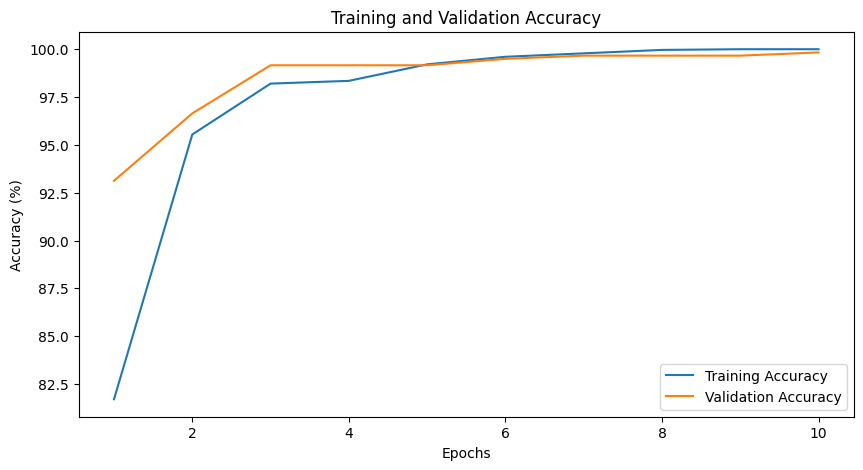

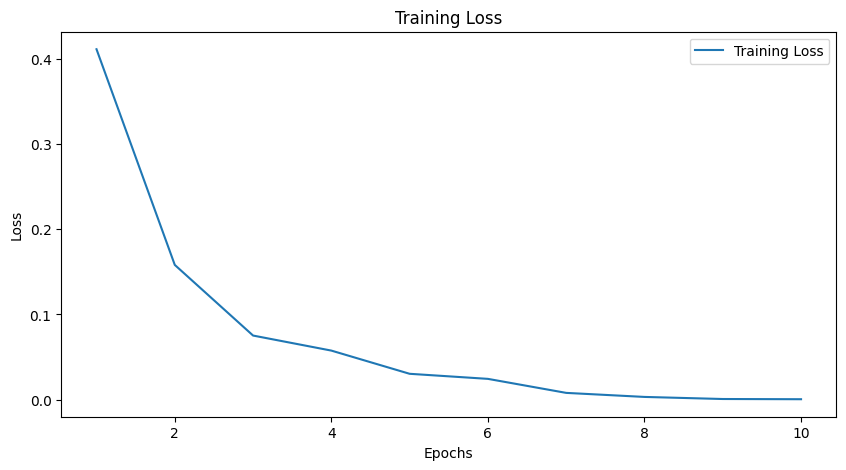

In [ ]:
# 设置gpu训练
device = torch.device("cuda")

train_loader = torch.load('../data/Dataloader_1D/train_loader.pth')
val_loader = torch.load('../data/Dataloader_1D/val_loader.pth')
test_loader = torch.load('../data/Dataloader_1D/test_loader.pth')

# 运行训练和测试
main(train_loader, val_loader, test_loader, device, num_epochs=10)
